# EIB Experiment Notebook

## Overview
This notebook demonstrates the complete workflow for the EIB (Example Image Benchmark) experiment. The workflow includes the following steps:

1. **Labels Check & Loading:**  
   Verify the existence of `labels.csv` and load or create labels from images in `../data/training_data`.

2. **Define Custom Configurations:**  
   Set up custom ReLU slopes and training epoch configurations.

3. **Model Training & Evaluation:**  
   - **Model Building:** Construct the CNN model using `build_EIB_cnn(...)` for each custom slope.
   - **Training:** Train the model with block-based splitting (using the first image in every block of 5 for testing) via `train_model(...)`.
   - **Feature Extraction & Correlation:** Extract intermediate features and compute the pairwise correlation matrix.
   - **Results Saving:** Save the correlation matrices and training/validation metrics (accuracy and loss) as JSON files under `../res/EIB/{epoch}/`.

4. **Visualization:**  
   Plot the training/validation curves and the correlation matrix using custom plotting functions.

---


In [1]:
# In[1] : Imports and Path Settings

import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from collections import defaultdict

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

# import module from 'src/preprocessing.py'
from preprocessing import load_dataset
from models import build_cnn, train_model
from analysis import (
    compute_correlations,
    visualize_c, 
    plot_metrics_acc,
    visualized_cor_mat
)
from utils import save_json, convert_to_serializable
from mid_layers import (
    visualize_activations_across_models,
    visualize_grouped_inactive_percentages,
    generate_avg_results_by_model,
)

## 1. Check and (if needed) Create Label CSV
If `../data/labels.csv` is not present, we load images from `../data/training_data/`,
generate the CSV, and store it. Otherwise, we read it and still load images/labels.


In [2]:
# In[2]: Checking/creating label CSV

label_csv_path = '../data/labels.csv'
data_folder = '../data/training_data'   # e.g. ../data/training_data/personA, ../data/training_data/personB, ...
target_size = (128, 128)                # desired image size

if not os.path.exists(label_csv_path):
    print("Label CSV not found. Generating from image folder...")
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)
    df.to_csv(label_csv_path, index=False)
    print(f"Saved new label CSV to {label_csv_path}")
else:
    print("Label CSV found. Reading it now...")
    df = pd.read_csv(label_csv_path)
    print("CSV preview (head):")
    print(df.head())
    # We still need images & labels in memory for training:
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)


dfPerson= pd.read_csv(label_csv_path)
personName = dfPerson.columns[1:].tolist()

print(f"DataFrame shape: {df.shape}")  # Should match labels count
print(f"Image count: {len(images_data)}")  # Should match labels count
print(f"Labels shape: {labels.shape}")  # (N, num_persons)
print(personName)

assert len(images_data) == labels.shape[0], "Mismatch between images and labels!"


Label CSV found. Reading it now...
CSV preview (head):
          img_id  juliana  kim  mai  michael  ntr  park  patrick  pedro  \
0  juliana_0.png        1    0    0        0    0     0        0      0   
1  juliana_1.png        1    0    0        0    0     0        0      0   
2  juliana_2.png        1    0    0        0    0     0        0      0   
3  juliana_3.png        1    0    0        0    0     0        0      0   
4  juliana_4.png        1    0    0        0    0     0        0      0   

   rachel  zen  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
DataFrame shape: (50, 11)
Image count: 50
Labels shape: (50, 10)
['juliana', 'kim', 'mai', 'michael', 'ntr', 'park', 'patrick', 'pedro', 'rachel', 'zen']


## 2. Define Custom Slopes, Epochs, and Iterations

Change or expand these lists as desired. For each slope in `custom_slope_list`,
we'll train the model for each number of slope in `ep` with `num` loops.


In [8]:
# In[3]: Custom Slopes & Epochs

custom_slope_list = [0.005, 0.05, 0.5]  # Example slopes for custom ReLU
noise_level = 0 # Example for Internal noise, auto = 0 
ep = 500      # Example epoch counts
num = 1  # Number of iterations

train_accuracies = defaultdict(list)
train_losses = defaultdict(list)
val_accuracies = defaultdict(list)
val_losses = defaultdict(list)
cor_dict = defaultdict(list)
trained_model = defaultdict(list) 

train_accuracies_dict = {}
train_loss_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}



## 3. Main Training Loop

The following code block implements the main training loop. For each iteration and for each custom ReLU slope, the loop:

1. **Clears Previous Metrics:** Resets dictionaries that store correlation matrices and training/validation metrics.
2. **Data Preparation:** Converts the preprocessed images (stored in `images_data`) to a NumPy array.
3. **Model Building:** Constructs a CNN model using the `build_EIB_cnn` function with the current custom slope.
4. **Model Training:** Trains the model using block-based splitting (the first image in every 5 is used for testing) via the `train_model` function.
5. **Metrics Storage:** Stores training and validation accuracy and loss metrics in dictionaries.
6. **Correlation Computation:** Extracts intermediate features using a designated layer and computes the pairwise correlation matrix using `compute_correlations`.
7. **Results Saving:** Converts the correlation matrices and metrics to a JSON-serializable format and saves them as JSON files.
8. **Metrics Plotting:** Visualizes the training and validation curves for accuracy and loss.




num_loop:   0%|          | 0/1 [00:00<?, ?it/s]

key =  (0.005, 0)
Epoch 1/500
1/1 [==============================] - 1s 761ms/step - loss: 0.6931 - accuracy: 0.1500 - val_loss: 0.6913 - val_accuracy: 0.1000
Epoch 2/500
1/1 [==============================] - 0s 234ms/step - loss: 0.6913 - accuracy: 0.0750 - val_loss: 0.6847 - val_accuracy: 0.1000
Epoch 3/500
1/1 [==============================] - 0s 231ms/step - loss: 0.6846 - accuracy: 0.0750 - val_loss: 0.6715 - val_accuracy: 0.1000
Epoch 4/500
1/1 [==============================] - 0s 235ms/step - loss: 0.6740 - accuracy: 0.1000 - val_loss: 0.6498 - val_accuracy: 0.1000
Epoch 5/500
1/1 [==============================] - 0s 228ms/step - loss: 0.6506 - accuracy: 0.1250 - val_loss: 0.6193 - val_accuracy: 0.1000
Epoch 6/500
1/1 [==============================] - 0s 222ms/step - loss: 0.6248 - accuracy: 0.0500 - val_loss: 0.5809 - val_accuracy: 0.1000
Epoch 7/500
1/1 [==============================] - 0s 296ms/step - loss: 0.5895 - accuracy: 0.1750 - val_loss: 0.5363 - val_accuracy: 0.

num_loop: 100%|██████████| 1/1 [06:05<00:00, 365.93s/it]


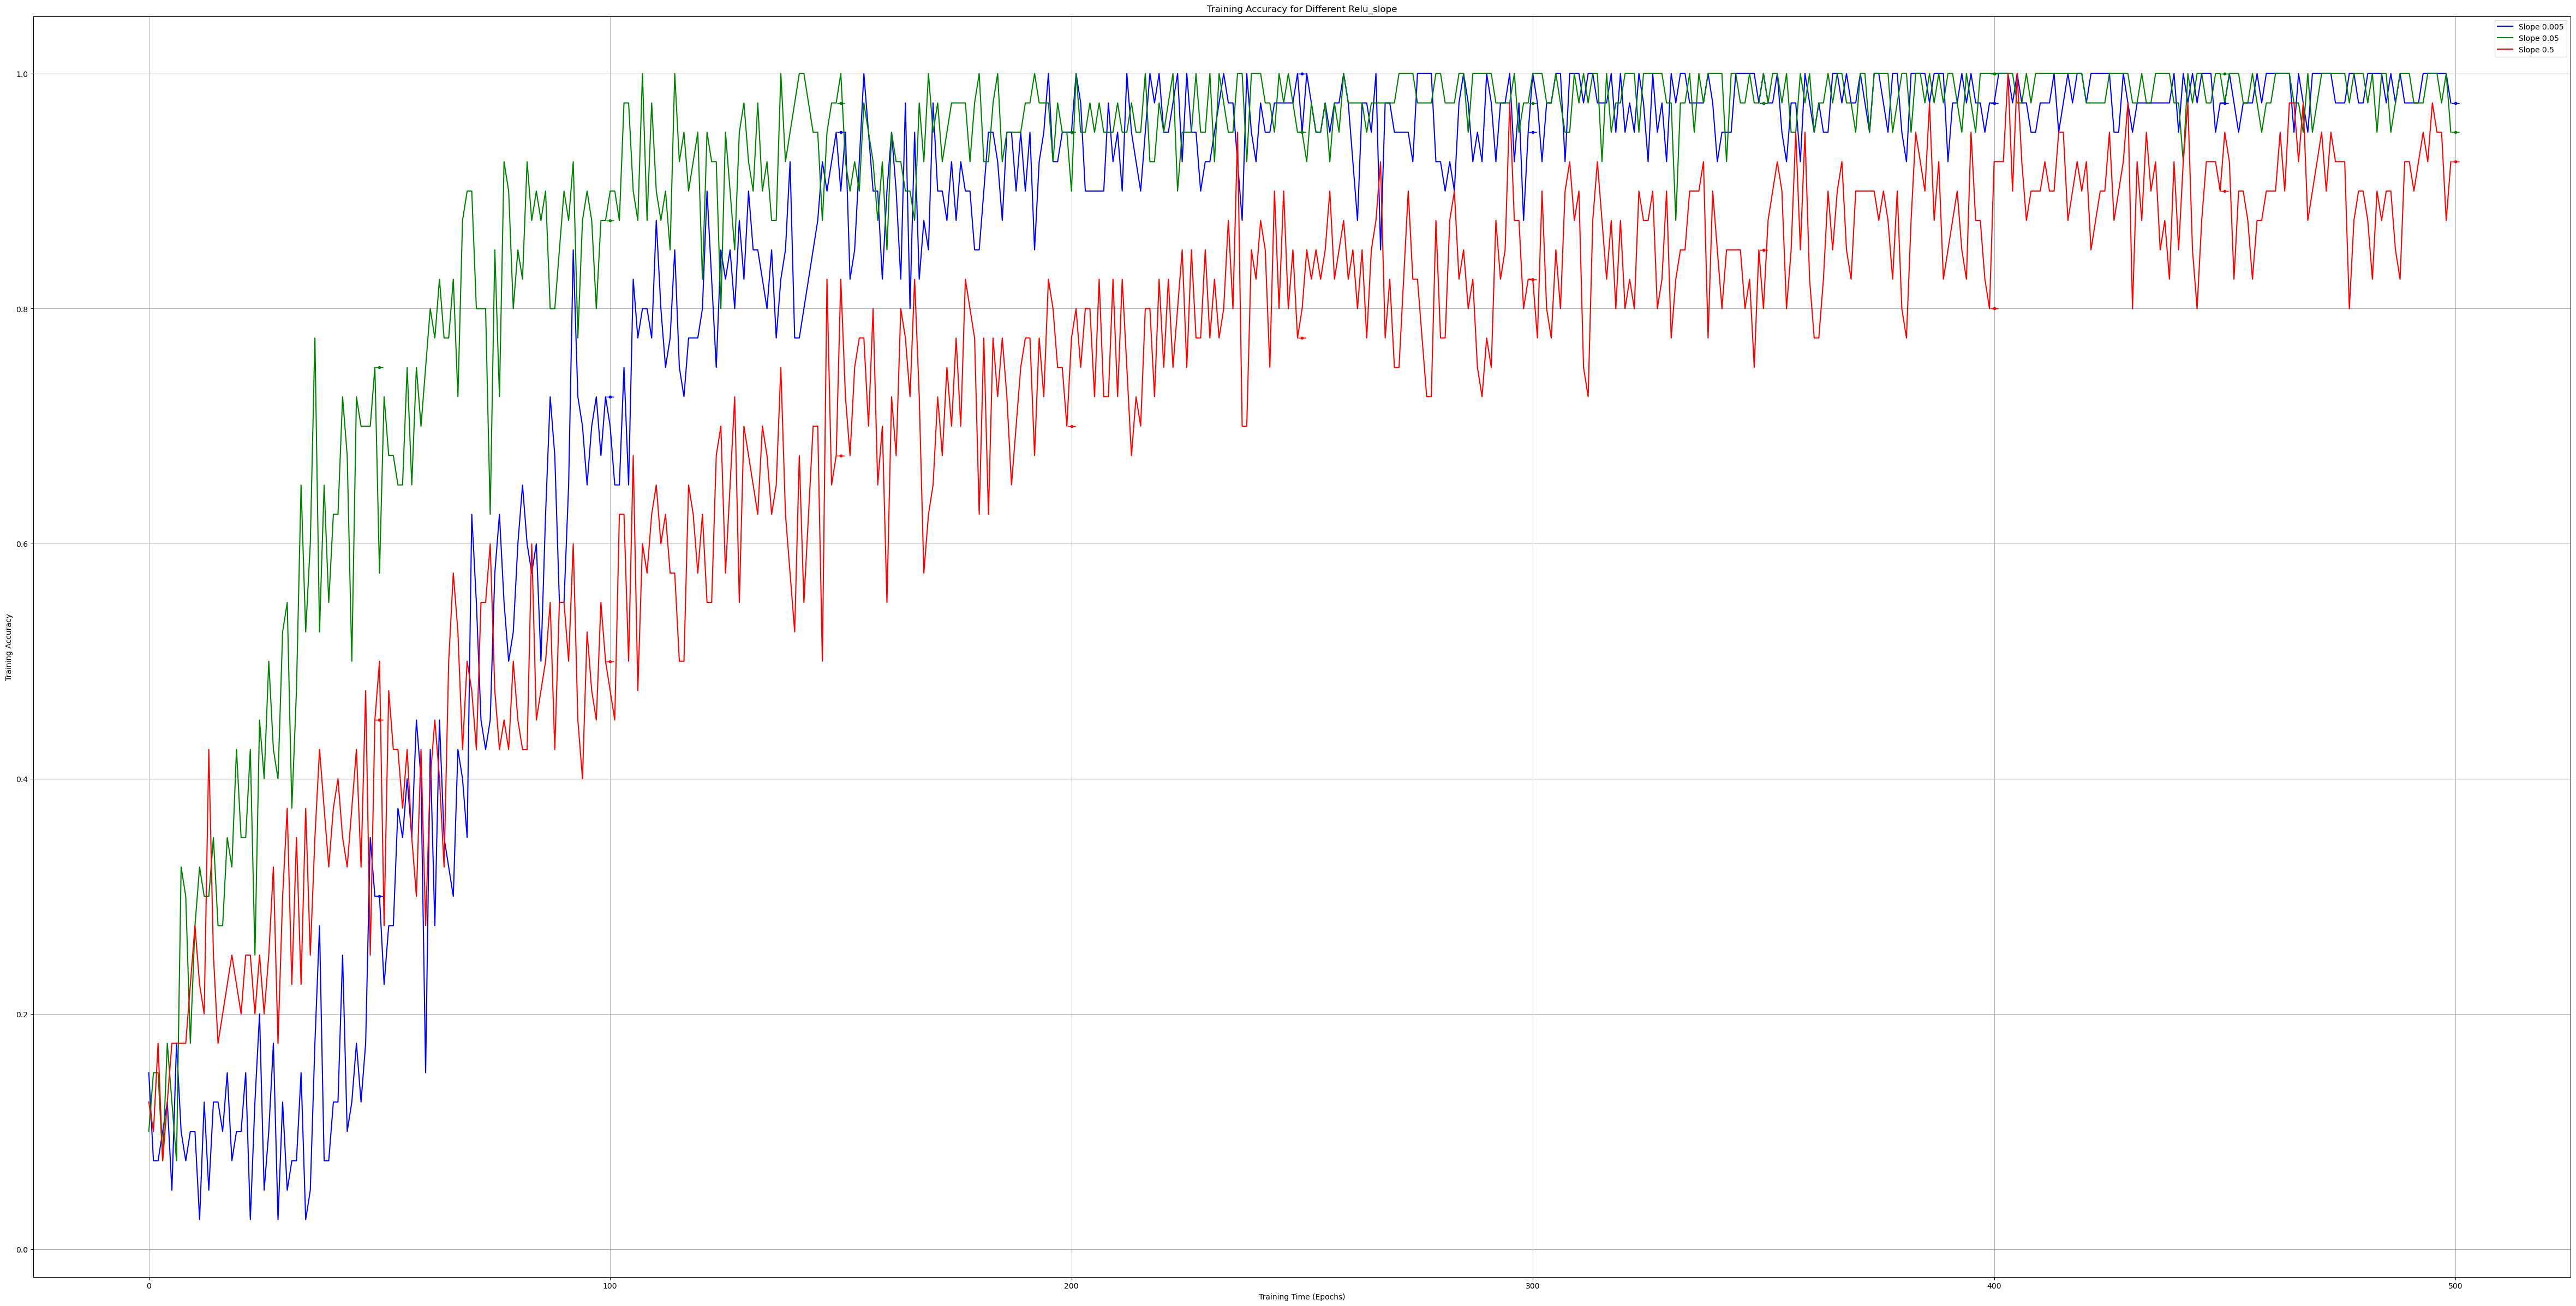

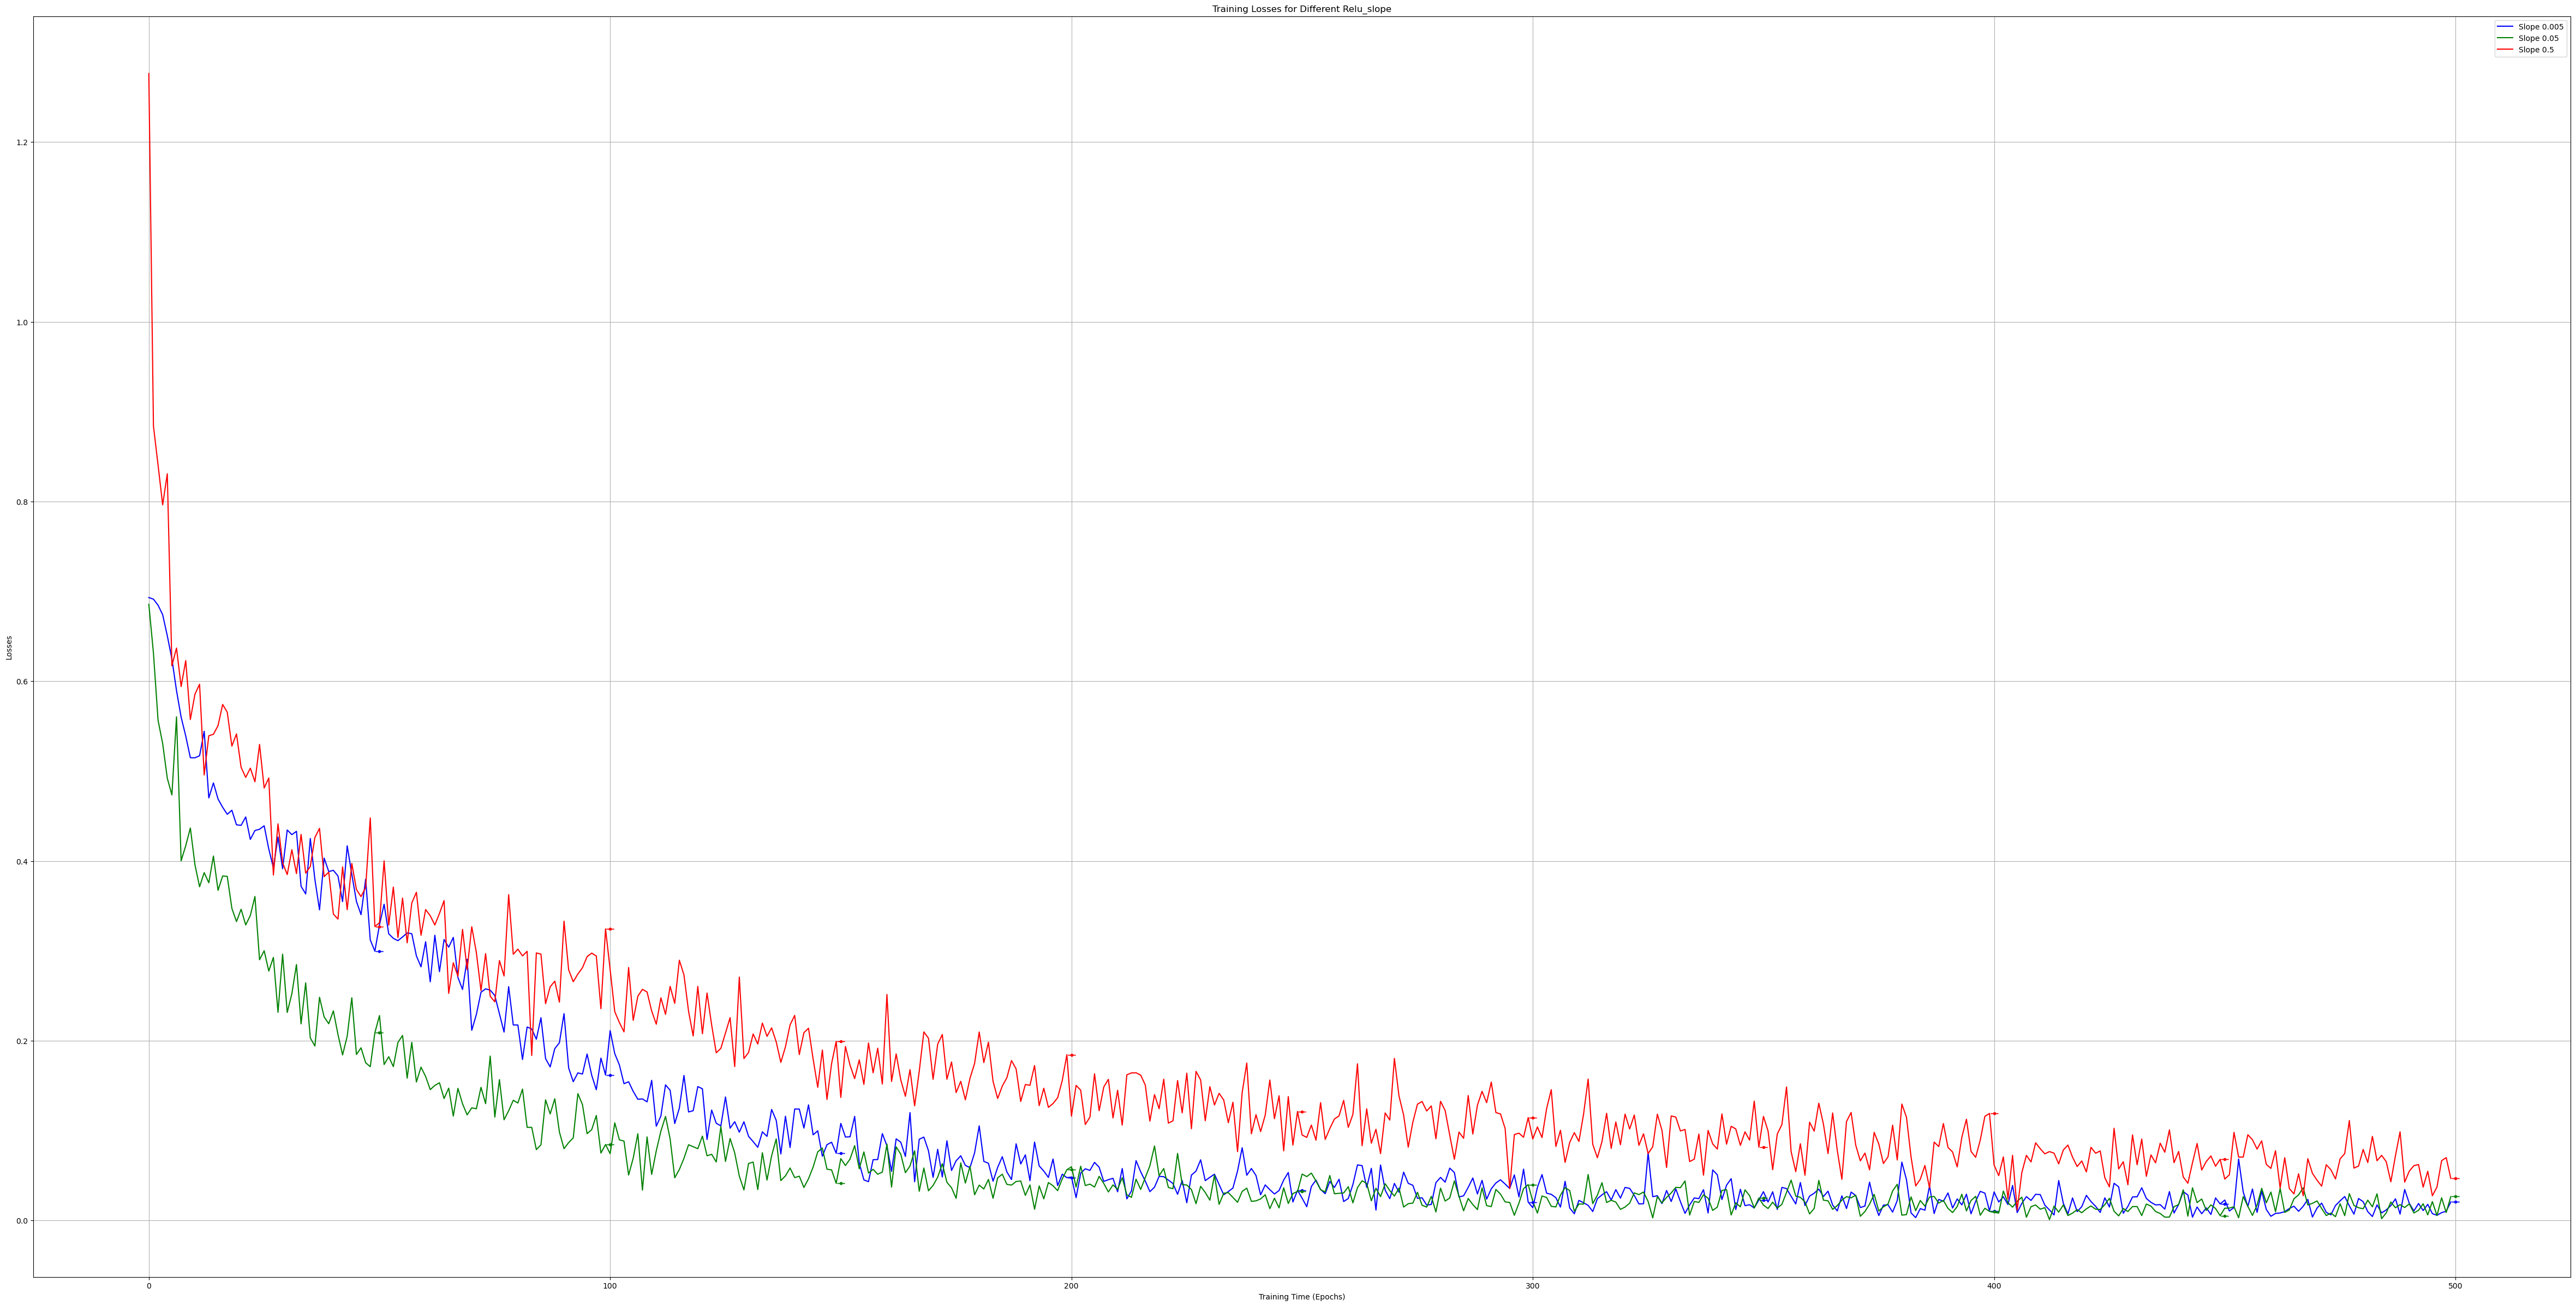

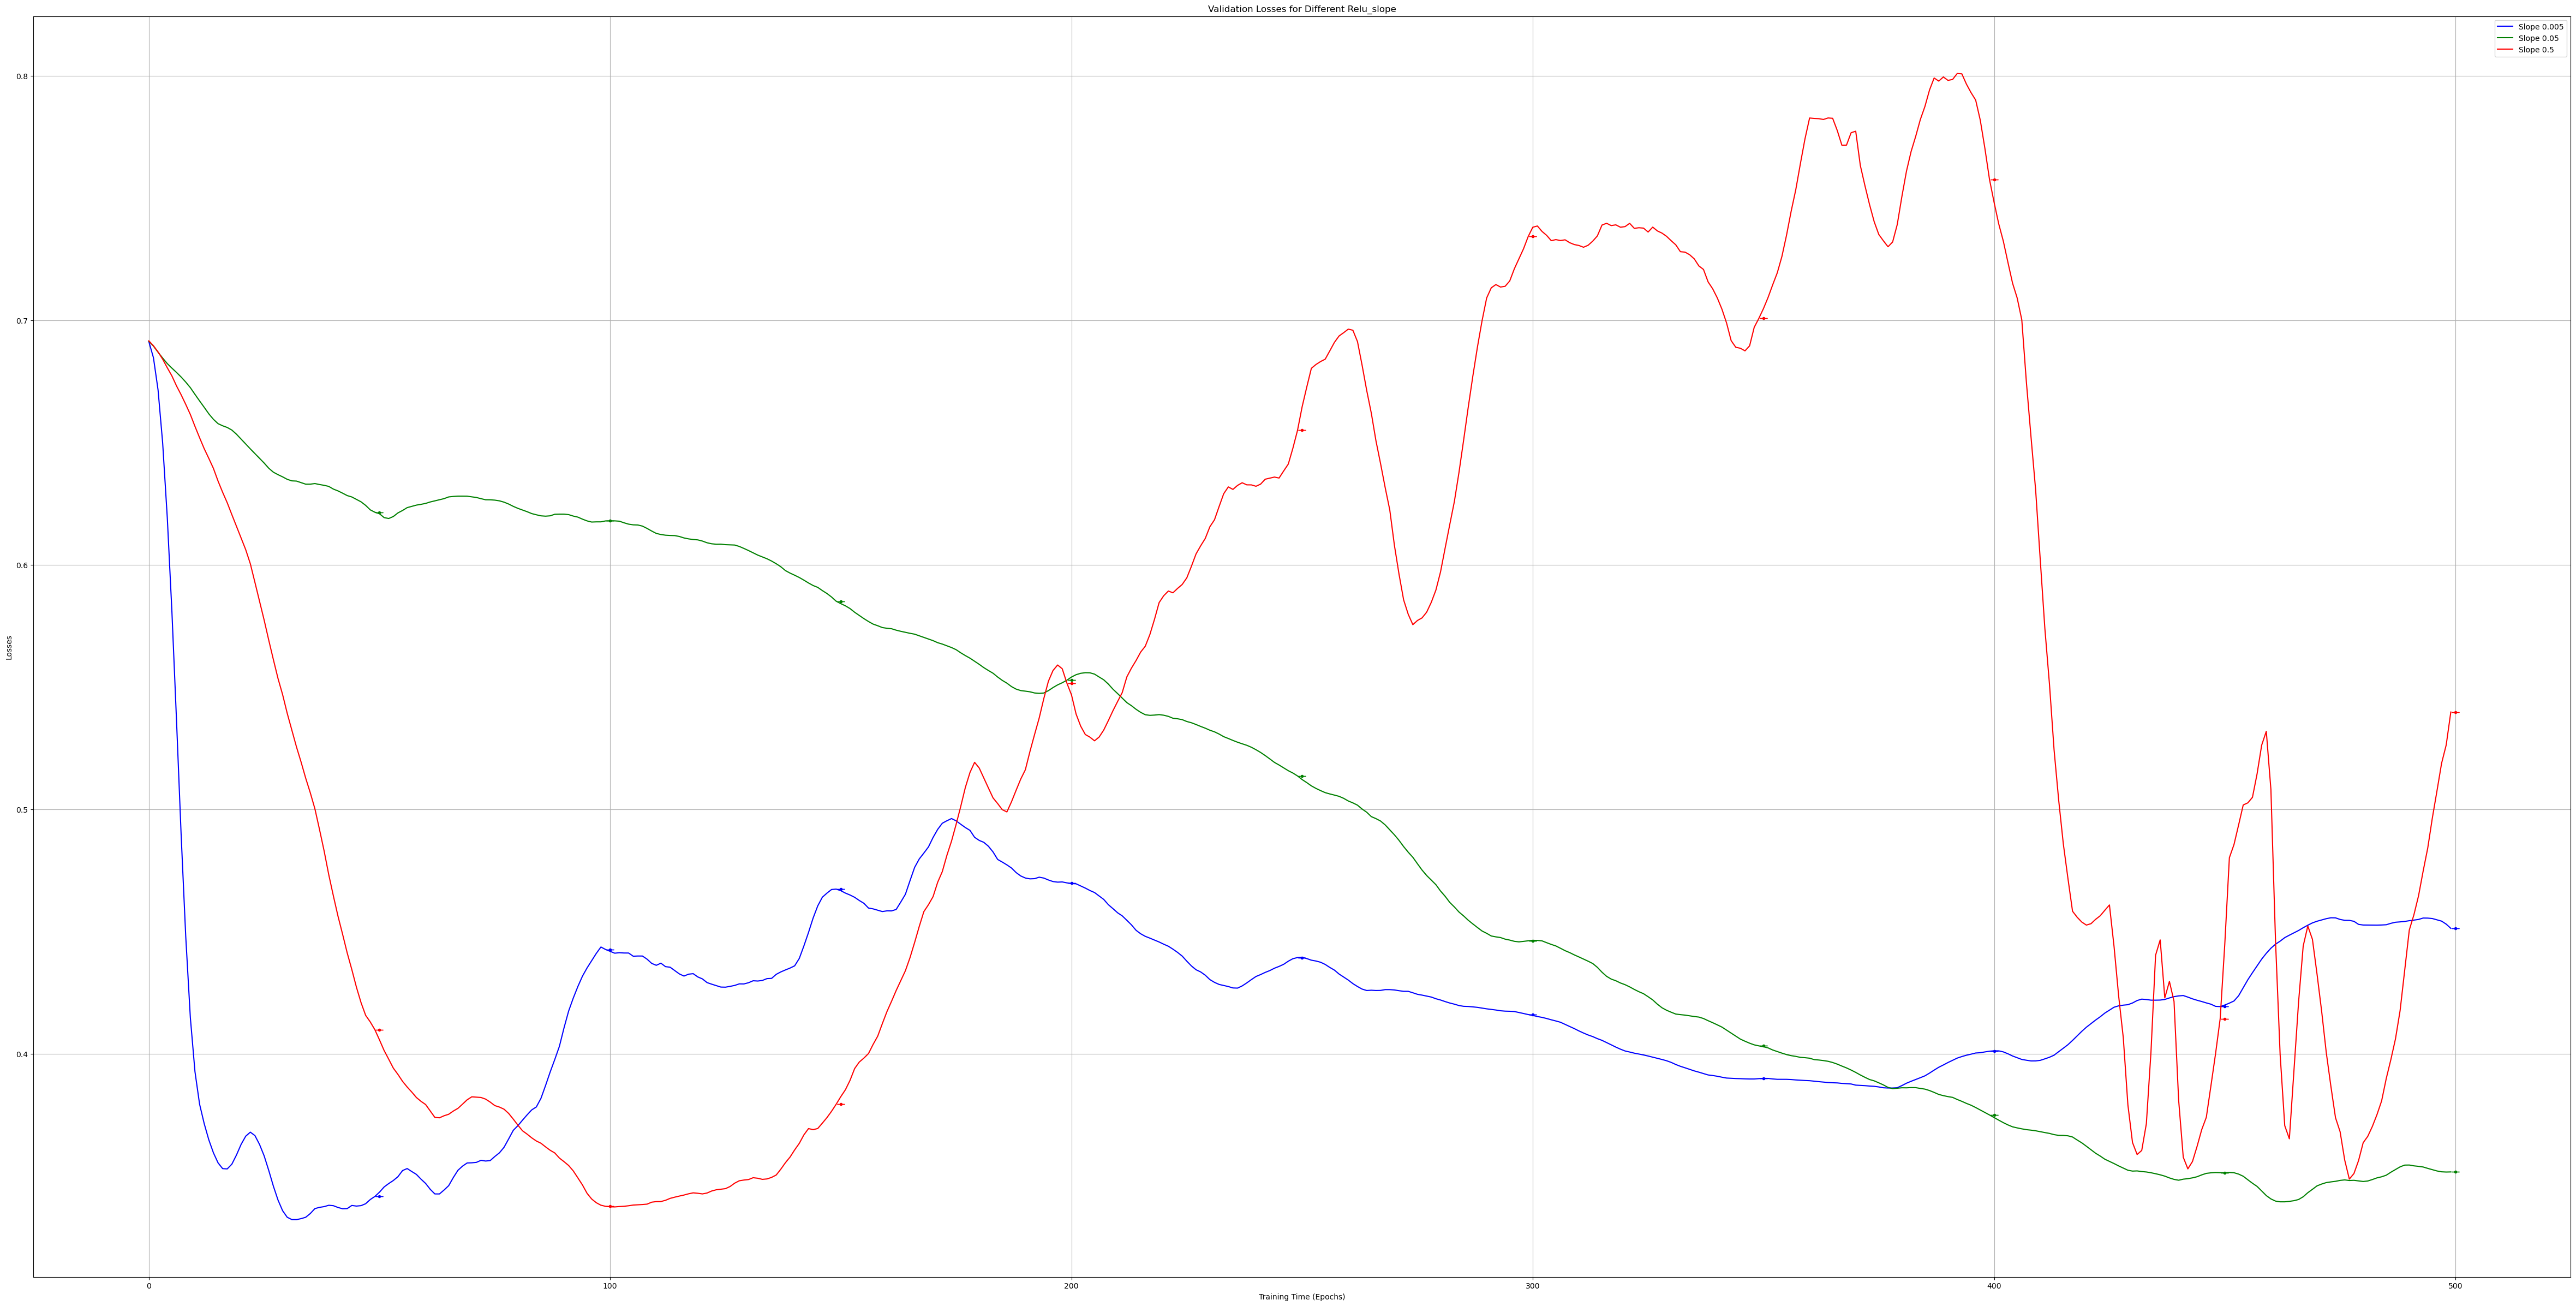

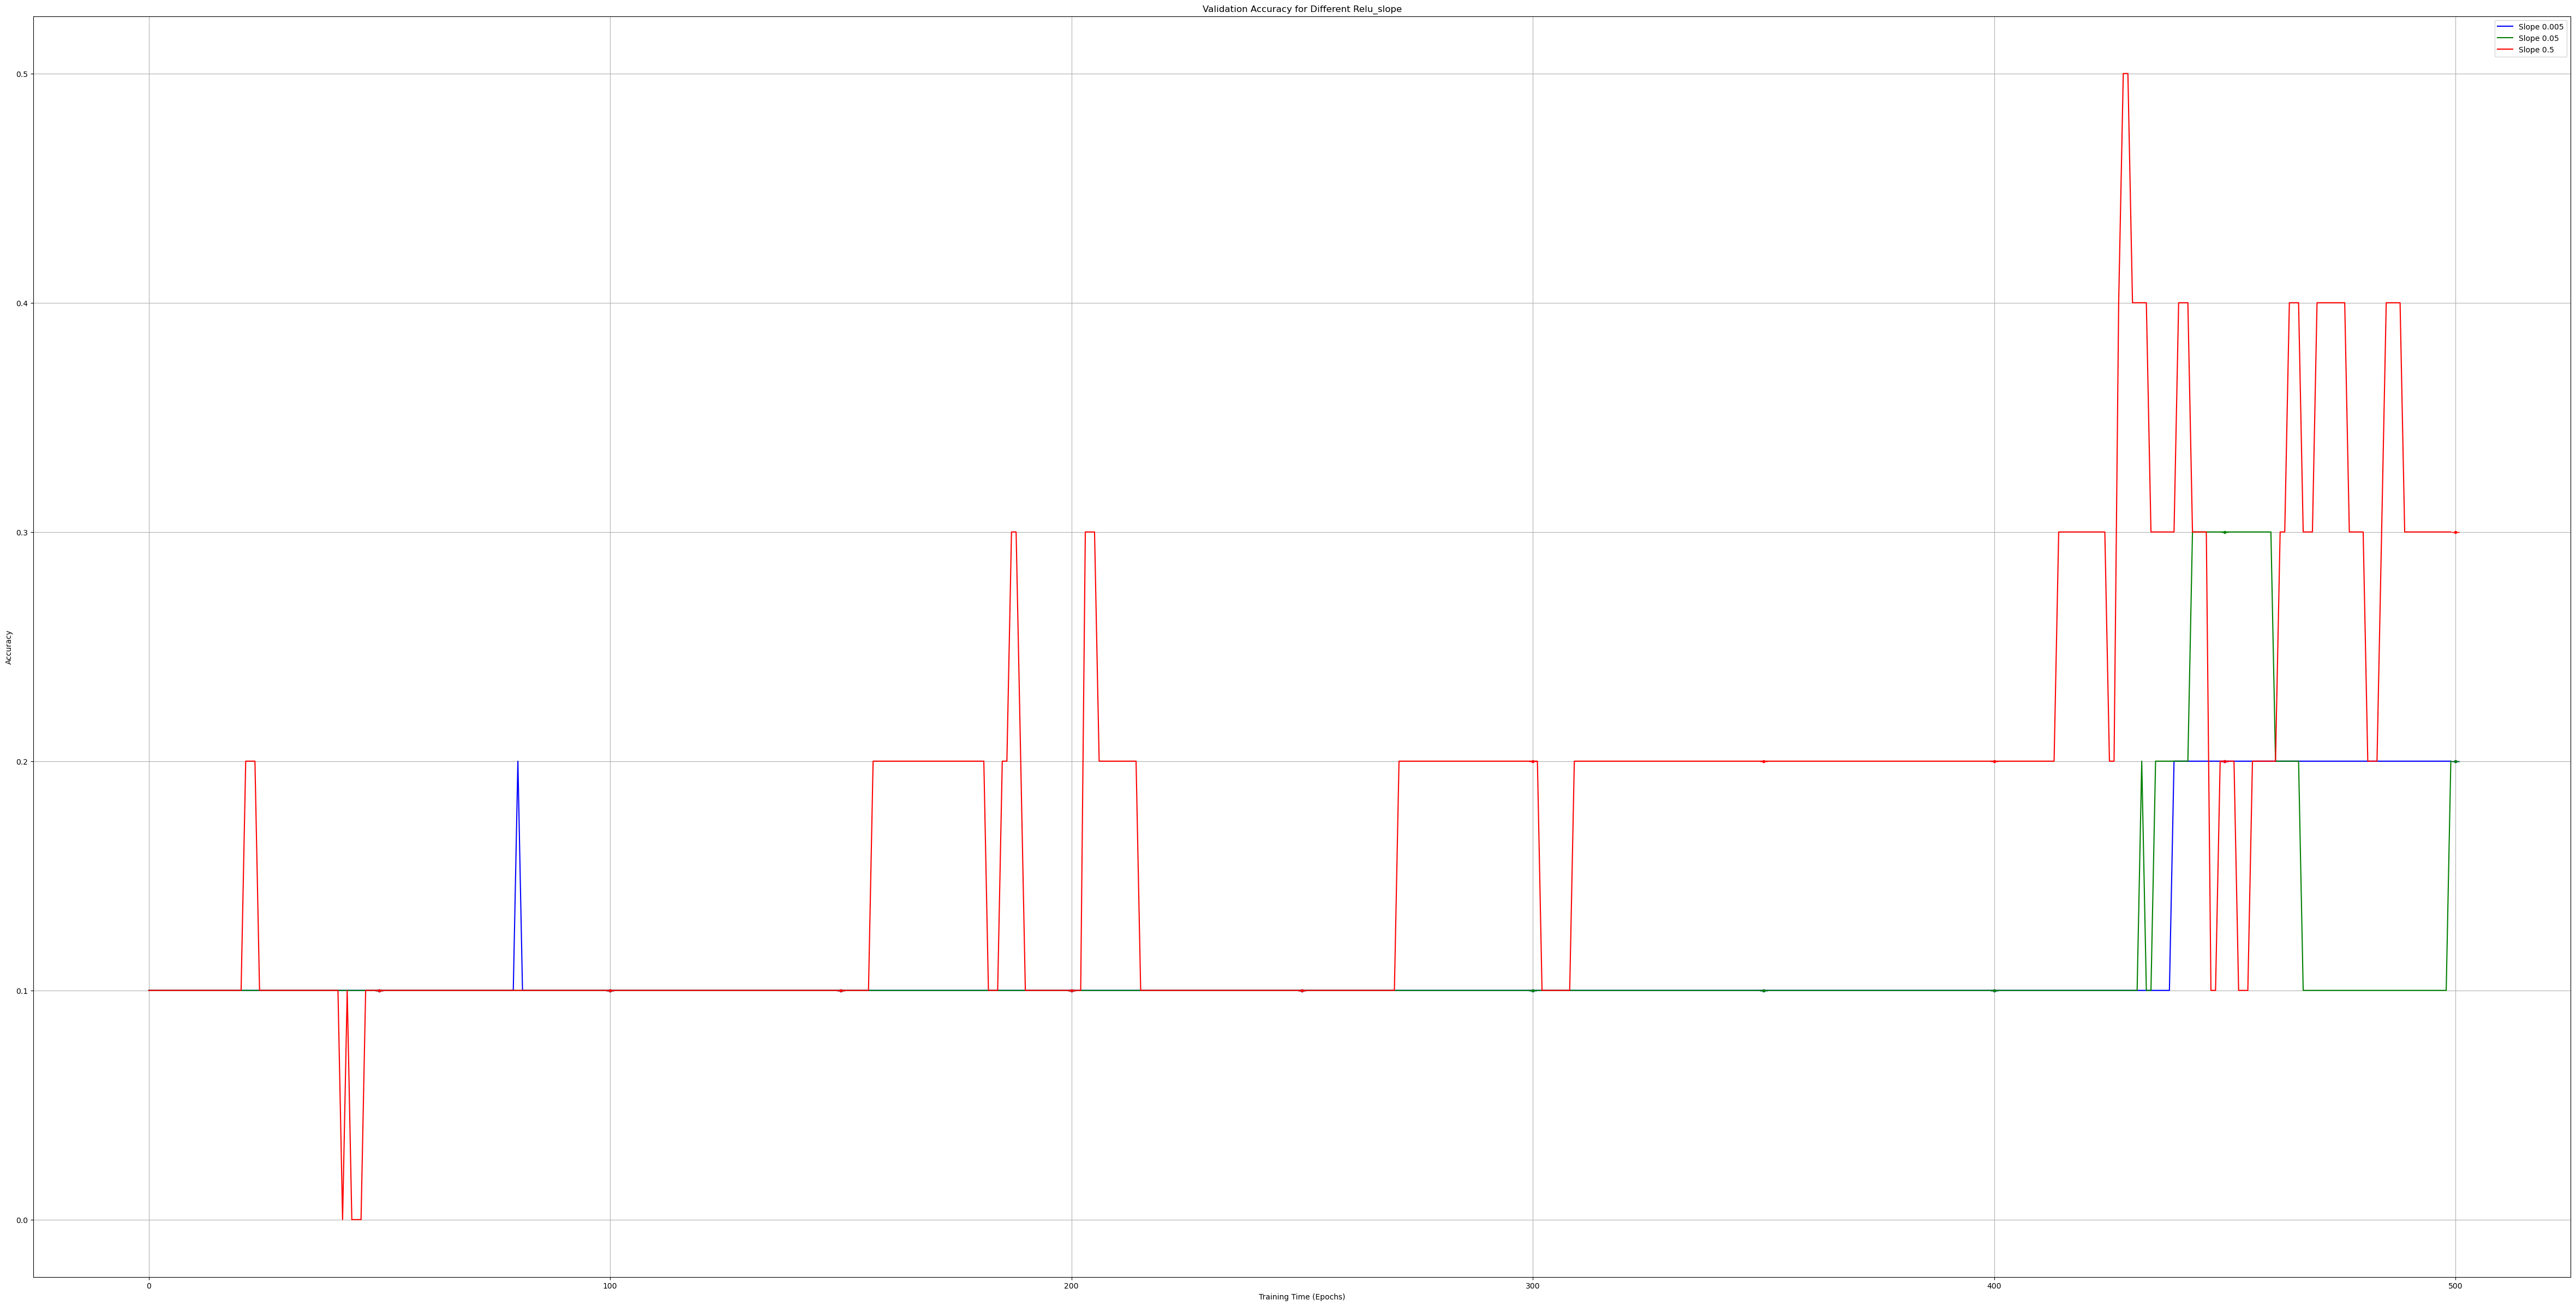

In [9]:
# In[4] : Main Training Loop
cor_dict.clear()
train_accuracies.clear()
train_losses.clear()
val_accuracies.clear()
val_losses.clear()
trained_model.clear()

data = np.array(list(images_data.values()))
ep_path = f'../res/EIB/{ep}'

for iteration in tqdm(range(num), desc='num_loop'):
    for s in custom_slope_list:
        key = (s, noise_level)
        print("key = ", key)
        
        
        model = build_cnn(
            input_shape=(130, 130, 3),
            slope_positive=s,
            noise_level=noise_level,
            filter_size=16,
            num_classes=labels.shape[1]
        )

        # 2) Train with block-based splitting (first image in every 5 is test)
        trainedAcc_data, trainedLoss_data, validationAcc_data, validationLoss_data = train_model(
            model,
            data,      # entire dataset
            df,           # entire label set
            n_epochs=ep,      # renamed to match the train_model function
            batch_size=64,
            verbose=1
        )

        trained_model[key].append(model)
        train_losses[s].append(trainedLoss_data)
        train_accuracies[s].append(trainedAcc_data)
        val_losses[s].append(validationLoss_data)
        val_accuracies[s].append(validationAcc_data)

        layer_name = f'least2_Dense_{s}_{noise_level}'
        
        # if s not in cor_dict:
        #     cor_dict[s] = []
        # c_arr = compute_correlations(images_data, model, layer_name)
        # cor_dict[s].append(c_arr)

        trainedAcc_data = convert_to_serializable(train_accuracies)
        trainedLoss_data = convert_to_serializable(train_losses)
        validationAcc_data = convert_to_serializable(val_accuracies)
        validationLoss_data = convert_to_serializable(val_losses)


        save_json(trainedAcc_data, f'{ep_path}/trainedAcc_{ep}.json')
        save_json(trainedLoss_data, f'{ep_path}/trainedLoss_{ep}.json')
        save_json(validationAcc_data, f'{ep_path}/validationAcc_{ep}.json')
        save_json(validationLoss_data, f'{ep_path}/validationLoss_{ep}.json')

converted_dict = convert_to_serializable(cor_dict)
outputFilePath = f'../res/EIB/{ep}/cor_output_{ep}_{iteration}.json'
save_json(converted_dict, outputFilePath)


plot_metrics_acc(train_accuracies, ep, 'Training Accuracy for Different Relu_slope', 'Training Accuracy')
plot_metrics_acc(train_losses, ep, 'Training Losses for Different Relu_slope', 'Losses')
plot_metrics_acc(val_losses, ep, 'Validation Losses for Different Relu_slope', 'Losses')
plot_metrics_acc(val_accuracies, ep, 'Validation Accuracy for Different Relu_slope', 'Accuracy')



## 3. Visualizing Correlational Matrix


In [5]:

visualized_cor_mat(1, ep, num, personName, slope=0.05)



KeyError: 0.05

## 4. Extracting and Visualizing Mid_Layer of trained CNN model(inactive_neurons)

In [10]:
relu_layers = [
    'conv_block1_relu', 
    'conv_block2_relu', 
    'conv_block3_relu'
]

layer_names_to_visualize = [
    'conv_block1_conv', 'conv_block1_relu',
    'conv_block2_conv', 'conv_block2_relu',
    'conv_block3_conv', 'conv_block3_relu'
]

cutomized_image_path = "../data/training_data/juliana/juliana_0.png"
target_size = 128
pad_value = 1
cmap = 'viridis' 

avg_results_by_model = generate_avg_results_by_model(trained_model, relu_layers, data_folder, target_size, pad_value)


1/1 [==============================] - 0s 12ms/step
Generated results for model key (0.005, 0): {'conv_block1_relu': 18.089467455621303, 'conv_block2_relu': 48.87550389680193, 'conv_block3_relu': 78.21204696745562}
1/1 [==============================] - 0s 12ms/step
Generated results for model key (0.05, 0): {'conv_block1_relu': 56.54940088757396, 'conv_block2_relu': 73.01214391292663, 'conv_block3_relu': 61.996856508875744}
1/1 [==============================] - 0s 12ms/step
Generated results for model key (0.5, 0): {'conv_block1_relu': 59.53758875739645, 'conv_block2_relu': 52.179572023649555, 'conv_block3_relu': 57.66457100591716}


1/1 [==============================] - 0s 18ms/step


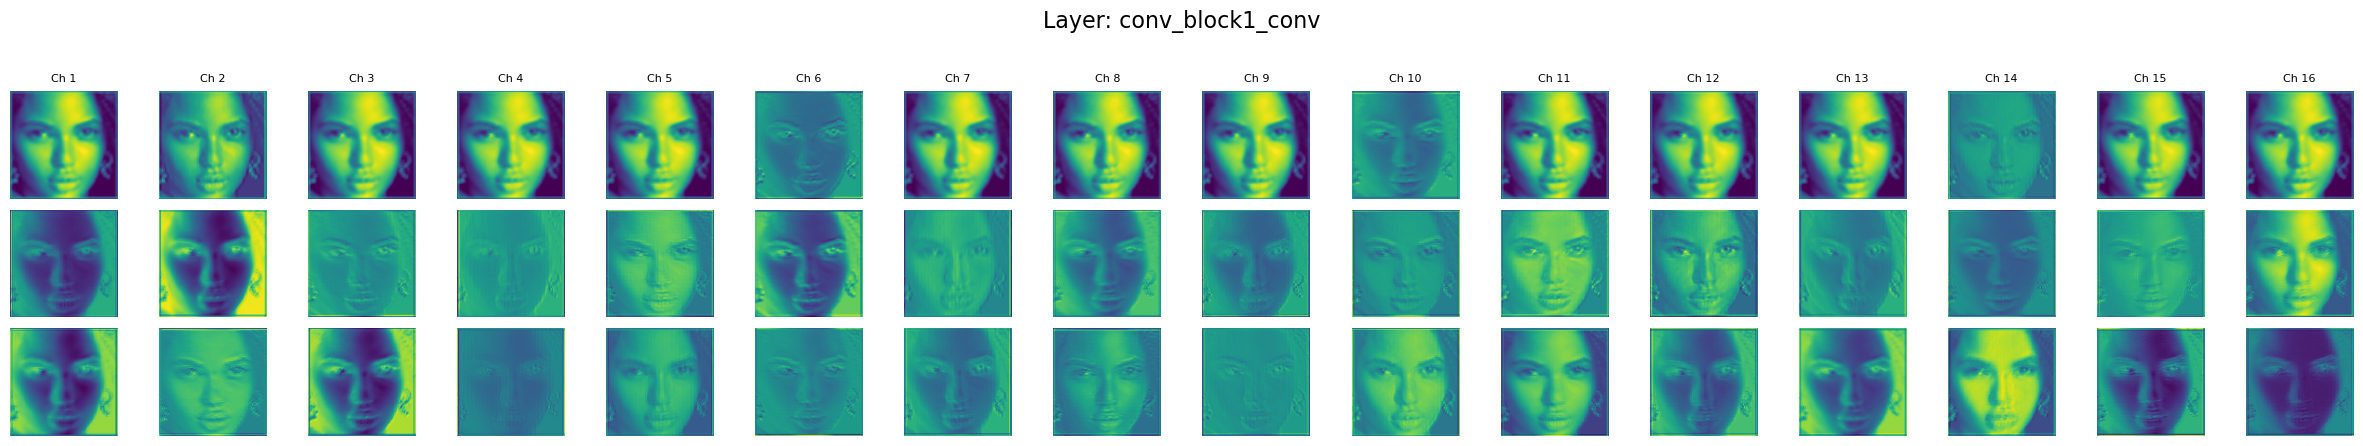

1/1 [==============================] - 0s 20ms/step


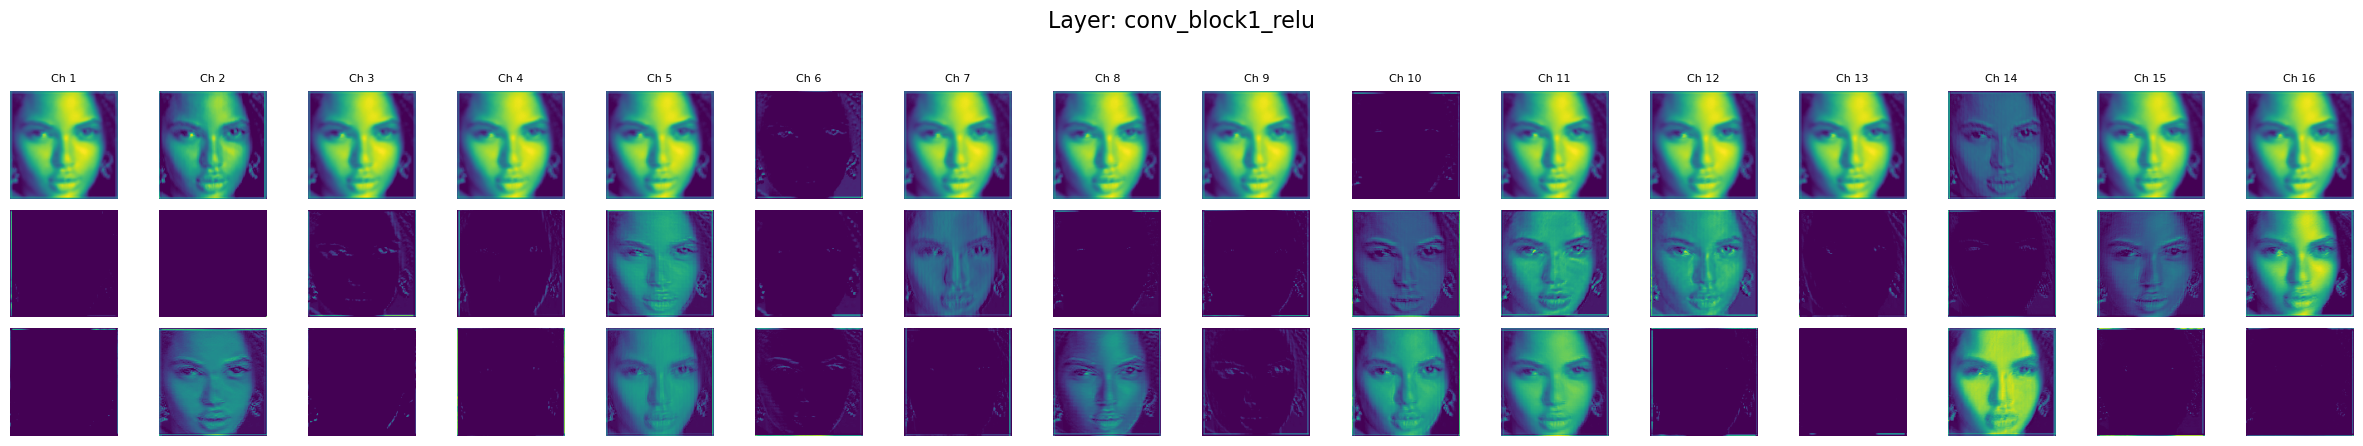

1/1 [==============================] - 0s 29ms/step


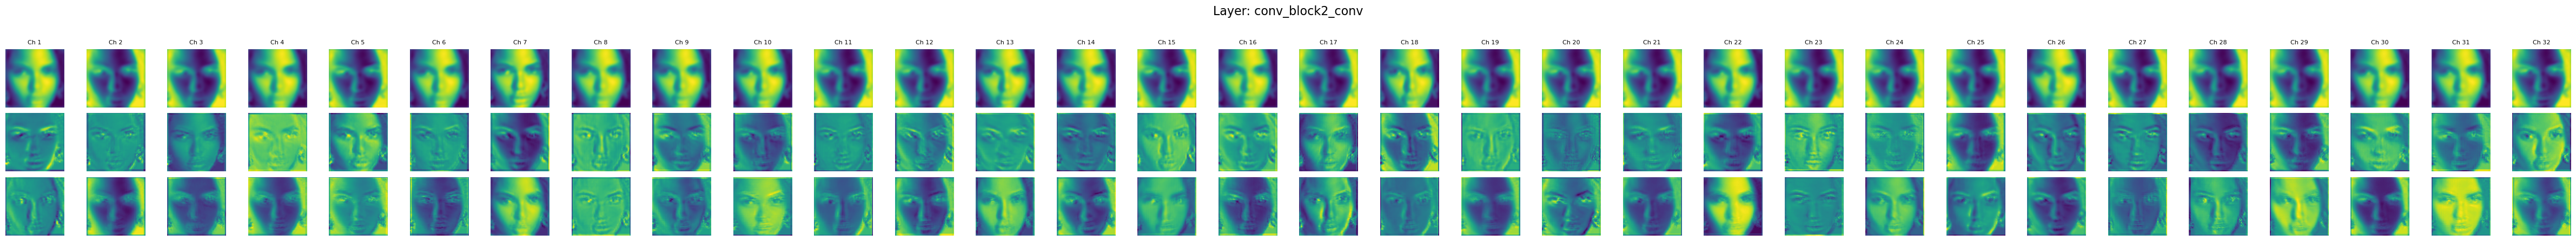

1/1 [==============================] - 0s 36ms/step


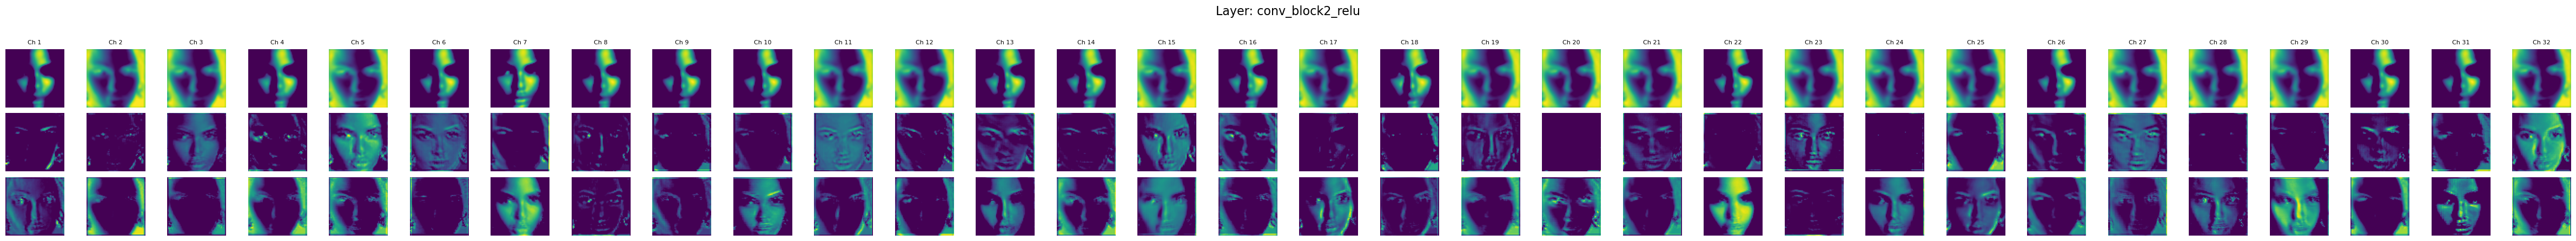

1/1 [==============================] - 0s 39ms/step


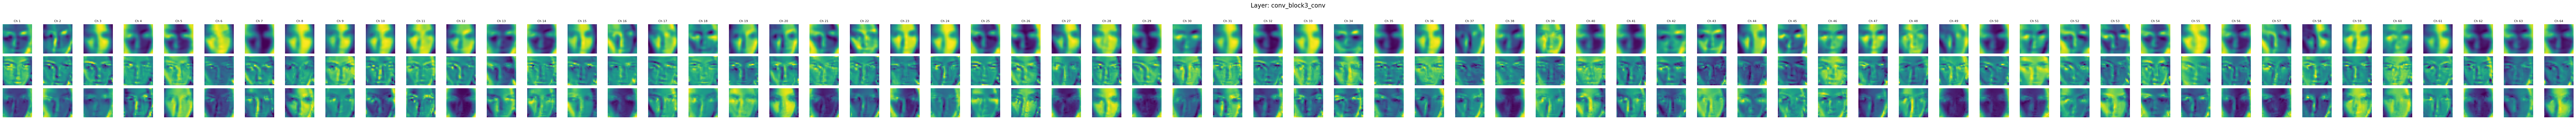

1/1 [==============================] - 0s 47ms/step


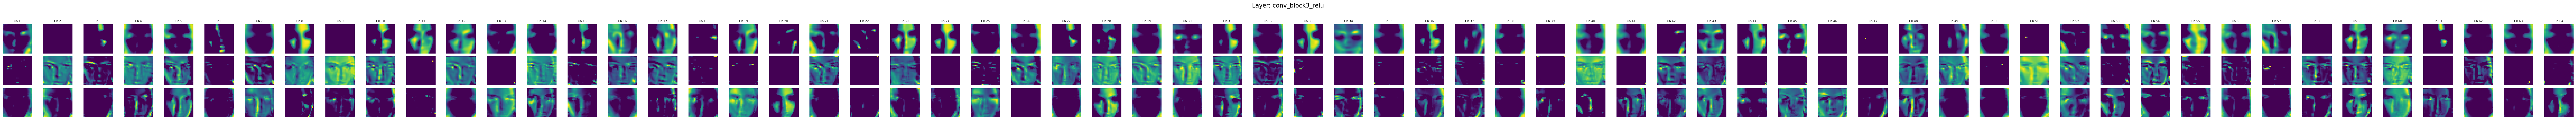

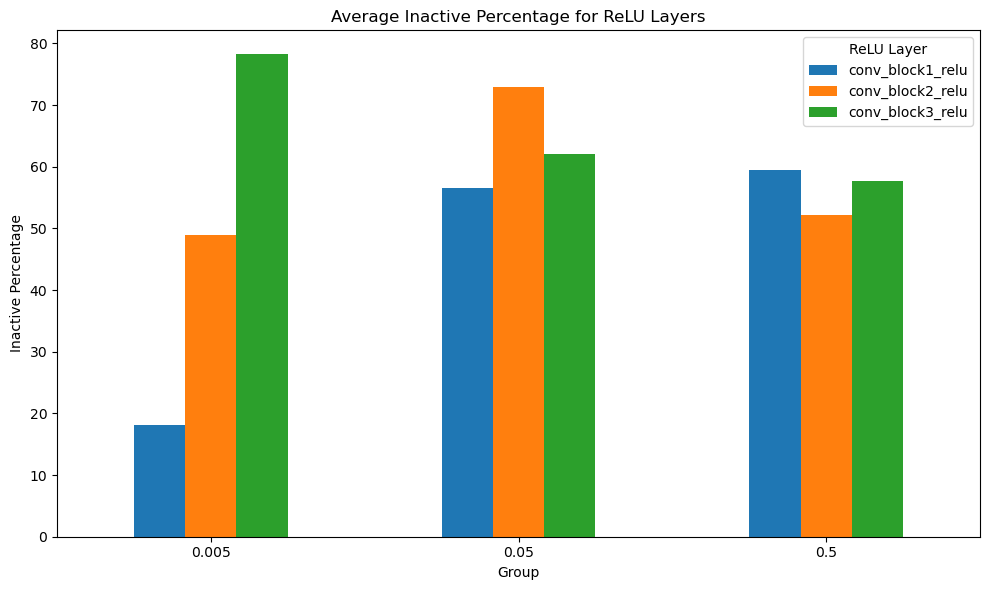

In [11]:

# For each layer, display a composite figure with each row corresponding to a model.
visualize_activations_across_models(trained_model, layer_names_to_visualize, cutomized_image_path, target_size, pad_value, cmap)
visualize_grouped_inactive_percentages(avg_results_by_model, relu_layers, "slope")

